In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Cargar el dataset
file_path = 'data/data.csv'
df = pd.read_csv(file_path, delimiter=';')

# Rellenar los valores faltantes en la variable 'V022_vent02_CO2' con su media
df['V022_vent02_CO2'] = df['V022_vent02_CO2'].fillna(df['V022_vent02_CO2'].mean())
df['V023_vent02_temp_out'] = df['V023_vent02_temp_out'].fillna(df['V023_vent02_temp_out'].mean())

# Convertir 'timestamp' a índice datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d.%m.%Y %H:%M')
df.set_index('timestamp', inplace=True)

# Agrupar por día manteniendo solo los días con 24 registros
daily_grouped = df.groupby(df.index.date).filter(lambda x: len(x) == 24)


# Crear un escalador para estandarizar ambas variables
scaler = StandardScaler()

# Aplicar estandarización a las dos columnas de interés
daily_grouped[['V022_vent02_CO2', 'V023_vent02_temp_out']] = scaler.fit_transform(daily_grouped[['V022_vent02_CO2', 'V023_vent02_temp_out']])

# Volver a agrupar por día después del filtro
daily_grouped = daily_grouped.groupby(daily_grouped.index.date)

# Convertir los datos agrupados en matrices de 24x1 para la variable 'V022_vent02_CO2'
daily_matrices = [group[['V022_vent02_CO2', 'V023_vent02_temp_out' ]].values for _, group in daily_grouped]
daily_matrices = np.array(daily_matrices)

arr_concatenated = np.hstack((daily_matrices[:, :, 0], daily_matrices[:, :, 1]))

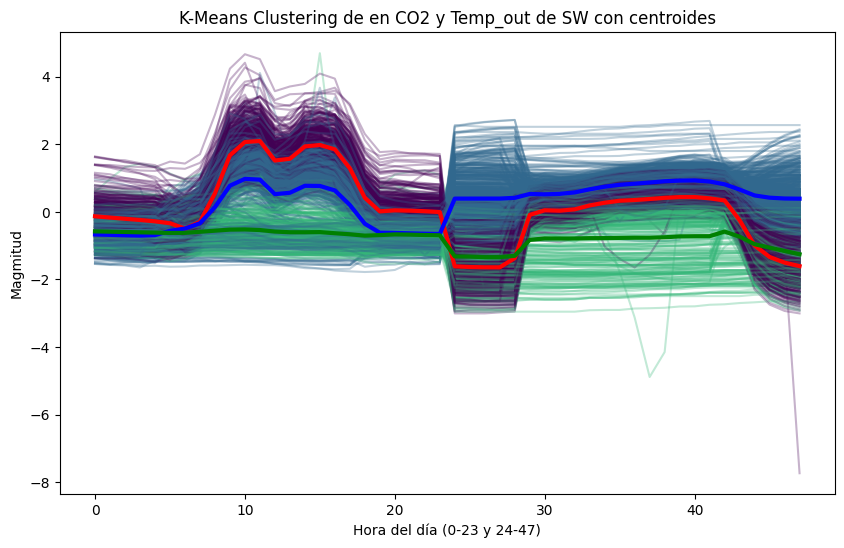

In [7]:
# Aplicar K-Means a los datos
n_clusters = 3  # Elige el número de clusters
daily_data = np.array([matrix for matrix in arr_concatenated  if len(matrix) == 48])

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_labels = kmeans.fit_predict(daily_data)
distances = kmeans.transform(daily_data)  # Distancias a los centroides

# Graficar los resultados de K-Means con los clusters en un gráfico de líneas
plt.figure(figsize=(10, 6))

# Graficar cada día como una línea, coloreada por su cluster
for i, (data, label) in enumerate(zip(daily_data, kmeans_labels)):
    plt.plot(range(48), data, color=plt.cm.viridis(label / n_clusters), alpha=0.3)

# Calcular y graficar los centroides con diferentes colores y más gruesos
centroides = kmeans.cluster_centers_
centroid_colors = ['red', 'blue', 'green']  # Colores para cada cluster
for i, centroide in enumerate(centroides):
    plt.plot(range(48), centroide, color=centroid_colors[i], linewidth=3)

# Ajustar el gráfico
plt.title("K-Means Clustering de en CO2 y Temp_out de SW con centroides")
plt.xlabel('Hora del día (0-23 y 24-47)')
plt.ylabel('Magmitud')

plt.show()

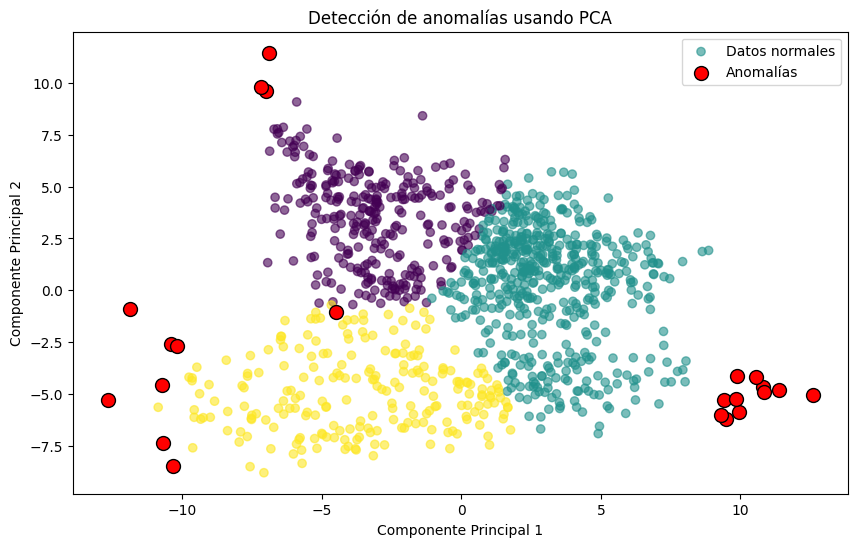

In [8]:
# Detectar anomalías: los puntos con mayor distancia a su cluster
threshold = np.percentile(np.min(distances, axis=1), 98)  # Tomar el 5% más alejado
anomalies = np.where(np.min(distances, axis=1) > threshold)[0]

# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=2)
pca_data = pca.fit_transform(daily_data)

# Graficar los resultados con anomalías
plt.figure(figsize=(10, 6))

# Graficar los puntos normales
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6, label='Datos normales')

# Resaltar las anomalías
plt.scatter(pca_data[anomalies, 0], pca_data[anomalies, 1], color='red', label='Anomalías', edgecolor='k', s=100)

# Ajustar el gráfico
plt.title("Detección de anomalías usando PCA")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()

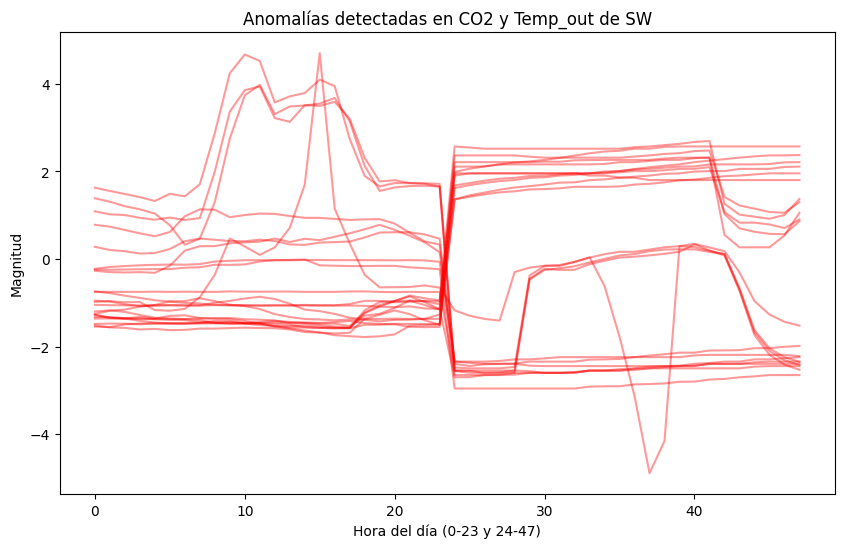

In [9]:
# Graficar las anomalías detectadas en un gráfico de líneas

plt.figure(figsize=(10, 6))

# Graficar las anomalías en un gráfico de líneas
for anomaly in anomalies:
    plt.plot(range(48), daily_data[anomaly], color='red', alpha=0.4)

# Ajustar el gráfico
plt.title("Anomalías detectadas en CO2 y Temp_out de SW")
plt.xlabel('Hora del día (0-23 y 24-47)')
plt.ylabel('Magnitud')
plt.show()